# Introduction to TensorFlow

Welcome to this week's programming assignment! Up until now, you've always used Numpy to build neural networks, but this week you'll explore a deep learning framework that allows you to build neural networks more easily. Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up your machine learning development significantly. TensorFlow 2.3 has made significant improvements over its predecessor, some of which you'll encounter and implement here!

By the end of this assignment, you'll be able to do the following in TensorFlow 2.3:

* Use `tf.Variable` to modify the state of a variable
* Explain the difference between a variable and a constant
* Train a Neural Network on a TensorFlow dataset

Programming frameworks like TensorFlow not only cut down on time spent coding, but can also perform optimizations that speed up the code itself. 

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/deep-neural-network/supplement/QWEnZ/h-ow-to-refresh-your-workspace).

## Table of Contents
- [1- Packages](#1)
    - [1.1 - Checking TensorFlow Version](#1-1)
- [2 - Basic Optimization with GradientTape](#2)
    - [2.1 - Linear Function](#2-1)
        - [Exercise 1 - linear_function](#ex-1)
    - [2.2 - Computing the Sigmoid](#2-2)
        - [Exercise 2 - sigmoid](#ex-2)
    - [2.3 - Using One Hot Encodings](#2-3)
        - [Exercise 3 - one_hot_matrix](#ex-3)
    - [2.4 - Initialize the Parameters](#2-4)
        - [Exercise 4 - initialize_parameters](#ex-4)
- [3 - Building Your First Neural Network in TensorFlow](#3)
    - [3.1 - Implement Forward Propagation](#3-1)
        - [Exercise 5 - forward_propagation](#ex-5)
    - [3.2 Compute the Cost](#3-2)
        - [Exercise 6 - compute_cost](#ex-6)
    - [3.3 - Train the Model](#3-3)
- [4 - Bibliography](#4)

<a name='1'></a>
## 1 - Packages

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

<a name='1-1'></a>
### 1.1 - Checking TensorFlow Version 

You will be using v2.3 for this assignment, for maximum speed and efficiency.

In [2]:
tf.__version__

'2.3.0'

<a name='2'></a>
## 2 - Basic Optimization with GradientTape

The beauty of TensorFlow 2 is in its simplicity. Basically, all you need to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with `GradientTape`. All that's left for you to do then is specify the cost function and optimizer you want to use! 

When writing a TensorFlow program, the main object to get used and transformed is the `tf.Tensor`. These tensors are the TensorFlow equivalent of Numpy arrays, i.e. multidimensional arrays of a given data type that also contain information about the computational graph.

Below, you'll use `tf.Variable` to store the state of your variables. Variables can only be created once as its initial value defines the variable shape and type. Additionally, the `dtype` arg in `tf.Variable` can be set to allow data to be converted to that type. But if none is specified, either the datatype will be kept if the initial value is a Tensor, or `convert_to_tensor` will decide. It's generally best for you to specify directly, so nothing breaks!


Here you'll call the TensorFlow dataset created on a HDF5 file, which you can use in place of a Numpy array to store your datasets. You can think of this as a TensorFlow data generator! 

You will use the Hand sign data set, that is composed of images with shape 64x64x3.

In [3]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [4]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [5]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

Since TensorFlow Datasets are generators, you can't access directly the contents unless you iterate over them in a for loop, or by explicitly creating a Python iterator using `iter` and consuming its
elements using `next`. Also, you can inspect the `shape` and `dtype` of each element using the `element_spec` attribute.

In [6]:
print(x_train.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [7]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


The dataset that you'll be using during this assignment is a subset of the sign language digits. It contains six different classes representing the digits from 0 to 5.

In [8]:
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

{0, 1, 2, 3, 4, 5}


You can see some of the images in the dataset by running the following cell.

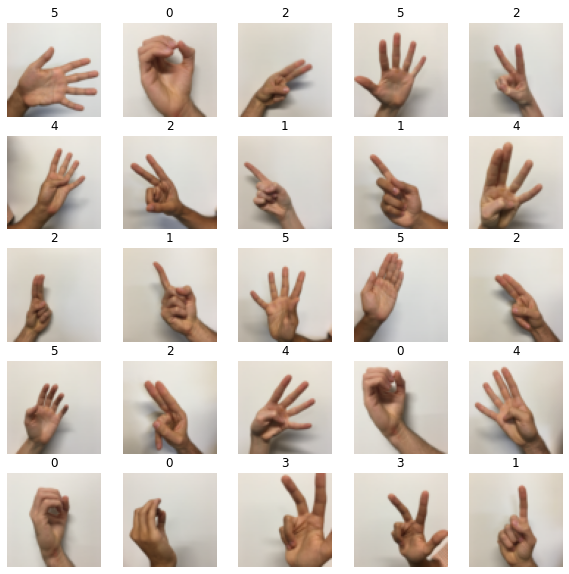

In [9]:
images_iter = iter(x_train)
labels_iter = iter(y_train)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

There's one more additional difference between TensorFlow datasets and Numpy arrays: If you need to transform one, you would invoke the `map` method to apply the function passed as an argument to each of the elements.

In [10]:
def normalize(image):
    """
    Transform an image into a tensor of shape (64 * 64 * 3, )
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
    return image

In [11]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [12]:
new_train.element_spec

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [13]:
print(next(iter(new_train)))

tf.Tensor([0.8901961  0.8627451  0.8392157  ... 0.8156863  0.81960785 0.81960785], shape=(12288,), dtype=float32)


<a name='2-1'></a>
### 2.1 - Linear Function

Let's begin this programming exercise by computing the following equation: $Y = WX + b$, where $W$ and $X$ are random matrices and b is a random vector. 

<a name='ex-1'></a>
### Exercise 1 - linear_function

Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. W is of shape (4, 3), X is (3,1) and b is (4,1). As an example, this is how to define a constant X with the shape (3,1):
```python
X = tf.constant(np.random.randn(3,1), name = "X")

```
Note that the difference between `tf.constant` and `tf.Variable` is that you can modify the state of a `tf.Variable` but cannot change the state of a `tf.constant`.

You might find the following functions helpful: 
- tf.matmul(..., ...) to do a matrix multiplication
- tf.add(..., ...) to do an addition
- np.random.randn(...) to initialize randomly

In [14]:
# GRADED FUNCTION: linear_function

def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """

    np.random.seed(1)
    
    """
    Note, to ensure that the "random" numbers generated match the expected results,
    please create the variables in the order given in the starting code below.
    (Do not re-arrange the order).
    """
    # (approx. 4 lines)
    # X = ...
    # W = ...
    # b = ...
    # Y = ...
    # YOUR CODE STARTS HERE
    
    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.constant(np.random.randn(4,3), name = "W")
    b = tf.constant(np.random.randn(4,1), name = "b")
    Y = tf.add(tf.matmul(W,X),b)
    
    # YOUR CODE ENDS HERE
    return Y

In [15]:
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll test passed")


tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All test passed


**Expected Output**: 

```
result = 
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]
```

<a name='2-2'></a>
### 2.2 - Computing the Sigmoid 
Amazing! You just implemented a linear function. TensorFlow offers a variety of commonly used neural network functions like `tf.sigmoid` and `tf.softmax`.

For this exercise, compute the sigmoid of z. 

In this exercise, you will: Cast your tensor to type `float32` using `tf.cast`, then compute the sigmoid using `tf.keras.activations.sigmoid`. 

<a name='ex-2'></a>
### Exercise 2 - sigmoid

Implement the sigmoid function below. You should use the following: 

- `tf.cast("...", tf.float32)`
- `tf.keras.activations.sigmoid("...")`

In [16]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """
    # tf.keras.activations.sigmoid requires float16, float32, float64, complex64, or complex128.
    
    # (approx. 2 lines)
    # z = ...
    # a = ...
    # YOUR CODE STARTS HERE
    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)
    
    # YOUR CODE ENDS HERE
    return a


In [17]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"
    assert sigmoid(12) == 0.9999939, "Error"

    print("\033[92mAll test passed")

sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.9999939, shape=(), dtype=float32)
All test passed


**Expected Output**: 
<table>
<tr> 
<td>
type
</td>
<td>
class 'tensorflow.python.framework.ops.EagerTensor'
</td>
</tr><tr> 
<td>
dtype
</td>
<td>
"dtype: 'float32'
</td>
</tr>
<tr> 
<td>
Sigmoid(-1)
</td>
<td>
0.2689414
</td>
</tr>
<tr> 
<td>
Sigmoid(0)
</td>
<td>
0.5
</td>
</tr>
<tr> 
<td>
Sigmoid(12)
</td>
<td>
0.999994
</td>
</tr> 

</table> 

<a name='2-3'></a>
### 2.3 - Using One Hot Encodings

Many times in deep learning you will have a $Y$ vector with numbers ranging from $0$ to $C-1$, where $C$ is the number of classes. If $C$ is for example 4, then you might have the following y vector which you will need to convert like this:


<img src="images/onehot.png" style="width:600px;height:150px;">

This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In TensorFlow, you can use one line of code: 

- [tf.one_hot(labels, depth, axis=0)](https://www.tensorflow.org/api_docs/python/tf/one_hot)

`axis=0` indicates the new axis is created at dimension 0

<a name='ex-3'></a>
### Exercise 3 - one_hot_matrix

Implement the function below to take one label and the total number of classes $C$, and return the one hot encoding in a column wise matrix. Use `tf.one_hot()` to do this, and `tf.reshape()` to reshape your one hot tensor! 

- `tf.reshape(tensor, shape)`

In [28]:
# GRADED FUNCTION: one_hot_matrix
def one_hot_matrix(label, depth=6):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    # (approx. 1 line)
    # one_hot = ...
    # YOUR CODE STARTS HERE
    print("Label "+str(label))
    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0), shape=(depth,))
    print("Onehot "+str(one_hot))
    
    # YOUR CODE ENDS HERE
    return one_hot

In [29]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print("Test 1:",result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 1. ,0., 0.] ), "Wrong output. Use tf.one_hot"
    label_2 = [2]
    result = target(label_2, depth)
    print("Test 2:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 0. ,1., 0.] ), "Wrong output. Use tf.reshape as instructed"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

Label tf.Tensor(1, shape=(), dtype=int32)
Onehot tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Label [2]
Onehot tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
All test passed


**Expected output**
```
Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
```

In [30]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

Label Tensor("args_0:0", shape=(), dtype=int64)
Onehot Tensor("Reshape:0", shape=(6,), dtype=float32)
Label Tensor("args_0:0", shape=(), dtype=int64)
Onehot Tensor("Reshape:0", shape=(6,), dtype=float32)


In [31]:
print(next(iter(new_y_test)))

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


<a name='2-4'></a>
### 2.4 - Initialize the Parameters 

Now you'll initialize a vector of numbers with the Glorot initializer. The function you'll be calling is `tf.keras.initializers.GlorotNormal`, which draws samples from a truncated normal distribution centered on 0, with `stddev = sqrt(2 / (fan_in + fan_out))`, where `fan_in` is the number of input units and `fan_out` is the number of output units, both in the weight tensor. 

To initialize with zeros or ones you could use `tf.zeros()` or `tf.ones()` instead. 

<a name='ex-4'></a>
### Exercise 4 - initialize_parameters

Implement the function below to take in a shape and to return an array of numbers using the GlorotNormal initializer. 

 - `tf.keras.initializers.GlorotNormal(seed=1)`
 - `tf.Variable(initializer(shape=())`

In [36]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    #(approx. 6 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # W3 = ...
    # b3 = ...
    # YOUR CODE STARTS HERE
    W1 = tf.Variable(initializer(shape=(25,12288)))
    b1 = tf.Variable(initializer(shape=(25,1)))
    W2 = tf.Variable(initializer(shape=(12,25)))
    b2 = tf.Variable(initializer(shape=(12,1)))
    W3 = tf.Variable(initializer(shape=(6,12)))
    b3 = tf.Variable(initializer(shape=(6,1)))
    
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [37]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


**Expected output**
```
W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
```

In [38]:
parameters = initialize_parameters()

<a name='3'></a>
## 3 - Building Your First Neural Network in TensorFlow

In this part of the assignment you will build a neural network using TensorFlow. Remember that there are two parts to implementing a TensorFlow model:

- Implement forward propagation
- Retrieve the gradients and train the model

Let's get into it!

<a name='3-1'></a>
### 3.1 - Implement Forward Propagation 

One of TensorFlow's great strengths lies in the fact that you only need to implement the forward propagation function and it will keep track of the operations you did to calculate the back propagation automatically.  


<a name='ex-5'></a>
### Exercise 5 - forward_propagation

Implement the `forward_propagation` function.

**Note** Use only the TF API. 

- tf.math.add
- tf.linalg.matmul
- tf.keras.activations.relu


In [39]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #(approx. 5 lines)                   # Numpy Equivalents:
    # Z1 = ...                           # Z1 = np.dot(W1, X) + b1
    # A1 = ...                           # A1 = relu(Z1)
    # Z2 = ...                           # Z2 = np.dot(W2, A1) + b2
    # A2 = ...                           # A2 = relu(Z2)
    # Z3 = ...                           # Z3 = np.dot(W3, A2) + b3
    # YOUR CODE STARTS HERE
    Z1 = tf.math.add(tf.linalg.matmul(W1,X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2,A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3,A2), b3)
    
    # YOUR CODE ENDS HERE
    
    return Z3

In [40]:
def forward_propagation_test(target, examples):
    minibatches = examples.batch(2)
    parametersk = initialize_parameters()
    W1 = parametersk['W1']
    b1 = parametersk['b1']
    W2 = parametersk['W2']
    b2 = parametersk['b2']
    W3 = parametersk['W3']
    b3 = parametersk['b3']
    index = 0
    minibatch = list(minibatches)[0]
    with tf.GradientTape() as tape:
        forward_pass = target(tf.transpose(minibatch), parametersk)
        print(forward_pass)
        fake_cost = tf.reduce_mean(forward_pass - np.ones((6,2)))

        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 2), "Last layer must use W3 and b3"
        assert np.allclose(forward_pass, 
                           [[-0.13430887,  0.14086473],
                            [ 0.21588647, -0.02582335],
                            [ 0.7059658,   0.6484556 ],
                            [-1.1260961,  -0.9329492 ],
                            [-0.20181894, -0.3382722 ],
                            [ 0.9558965,   0.94167566]]), "Output does not match"
    index = index + 1
    trainable_variables = [W1, b1, W2, b2, W3, b3]
    grads = tape.gradient(fake_cost, trainable_variables)
    assert not(None in grads), "Wrong gradients. It could be due to the use of tf.Variable whithin forward_propagation"
    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

tf.Tensor(
[[-0.13430887  0.14086473]
 [ 0.21588647 -0.02582335]
 [ 0.7059658   0.6484556 ]
 [-1.1260961  -0.9329492 ]
 [-0.20181894 -0.3382722 ]
 [ 0.9558965   0.94167566]], shape=(6, 2), dtype=float32)
All test passed


**Expected output**
```
tf.Tensor(
[[-0.13430887  0.14086473]
 [ 0.21588647 -0.02582335]
 [ 0.7059658   0.6484556 ]
 [-1.1260961  -0.9329492 ]
 [-0.20181894 -0.3382722 ]
 [ 0.9558965   0.94167566]], shape=(6, 2), dtype=float32)
```

<a name='3-2'></a>
### 3.2 Compute the Cost

All you have to do now is define the loss function that you're going to use. For this case, since we have a classification problem with 6 labels, a categorical cross entropy will work! 

<a name='ex-6'></a>
### Exercise 6 -  compute_cost

Implement the cost function below. 
- It's important to note that the "`y_pred`" and "`y_true`" inputs of [tf.keras.losses.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) are expected to be of shape (number of examples, num_classes). 

- `tf.reduce_sum` does the summation over the examples.

In [73]:
# GRADED FUNCTION: compute_cost 

def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    #(1 line of code)
    # cost = ...
    # YOUR CODE STARTS HERE
    cost = tf.keras.losses.categorical_crossentropy(tf.transpose(labels), tf.transpose(logits), from_logits = True)
    cost = tf.reduce_sum(cost)

    
    # YOUR CODE ENDS HERE
    return cost

In [74]:
def compute_cost_test(target, Y):
    pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
    minibatches = Y.batch(2)
    for minibatch in minibatches:
        result = target(pred, tf.transpose(minibatch))
        break
        
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.50722074 + 1.1133534) / 2.0) < 1e-7), "Test does not match. Did you get the reduce sum of your cost functions?"

    print("\033[92mAll test passed")

compute_cost_test(compute_cost, new_y_train )

Labels
tf.Tensor(
[[0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]], shape=(6, 2), dtype=float32)
logits
tf.Tensor(
[[ 2.4048107   5.0334096 ]
 [-0.7921977  -4.1523376 ]
 [ 0.9447198  -0.46802214]
 [ 1.158121    3.9810789 ]
 [ 4.768706    2.3220146 ]
 [ 6.1481323   3.909829  ]], shape=(6, 2), dtype=float32)
cost1
tf.Tensor([0.25361034 0.5566767 ], shape=(2,), dtype=float32)
cost2
tf.Tensor(0.810287, shape=(), dtype=float32)
tf.Tensor(0.810287, shape=(), dtype=float32)
All test passed


**Expected output**
```
tf.Tensor(0.810287, shape=(), dtype=float32)
```

<a name='3-3'></a>
### 3.3 - Train the Model

Let's talk optimizers. You'll specify the type of optimizer in one line, in this case `tf.keras.optimizers.Adam` (though you can use others such as SGD), and then call it within the training loop. 

Notice the `tape.gradient` function: this allows you to retrieve the operations recorded for automatic differentiation inside the `GradientTape` block. Then, calling the optimizer method `apply_gradients`, will apply the optimizer's update rules to each trainable parameter. At the end of this assignment, you'll find some documentation that explains this more in detail, but for now, a simple explanation will do. ;) 


Here you should take note of an important extra step that's been added to the batch training process: 

- `tf.Data.dataset = dataset.prefetch(8)` 

What this does is prevent a memory bottleneck that can occur when reading from disk. `prefetch()` sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory. 

In [75]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    #(1 line)
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    #X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    #Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches:
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # 2. loss
                minibatch_cost = compute_cost(Z3, tf.transpose(minibatch_Y))

            # We accumulate the accuracy of all the batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost
        
        # We divide the epoch cost over the number of samples
        epoch_cost /= m

        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print("Train accuracy:", train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()


    return parameters, costs, train_acc, test_acc

In [ ]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.3430887e-01  1.4086467e-01 -5.0759785e-02  5.7929289e-02
   4.1665584e-03  2.0375613e-02  7.9874031e-02 -1.9228227e-02
  -4.0939800e-02  3.8570695e-02  4.1316450e-03  7.6712914e-02
   5.0756566e-02 -1.9767910e-01  4.9716890e-02 -7.3008083e-02
   5.6818802e-02 -3.1878397e-02  3.6695428e-02  4.3900114e-02
   8.6034529e-02

Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 1. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.23087181 -0.28392047 -0.33367634 -0.25574094 -0.44207406 -0.4269536
  -0.35242236 -0.3622198  -0.12677762 -0.27705687 -0.41044492  0.17163047
  -0.15313998 -0.3941995  -0.2128755  -0.24025701 -0.3248977  -0.13157958
  -0.2682743  -0.34022528 -0.19592102 -0.14533257 -0.23396884 -0.3297404
  -0.3548671  -0.10133912 -0.250

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.60961694 -0.30627343 -0.62064445 -0.6612219  -0.22499046 -0.61561364
  -0.30732054 -0.5799376  -0.08888804 -0.73417705 -0.52088886 -0.36852038
  -0.56949115 -0.62416977 -0.4824639  -0.6139751  -0.6832373  -0.5516688
  -0.2315166  -0.7521225  -0.53669804 -0.62729686 -0.3515511  -0.79378235
  -0.34245977 -0.40100193 -0.63

 1.4692242 1.3955743 2.2083688 1.8034171], shape=(32,), dtype=float32)
cost2
tf.Tensor(55.089306, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.31707168 -0.13518462 -0.3517784  -0.03621229 -0.03205711  0.03809373
   0.04472075 -0.19493288 -0.2617941  -0.02571149 -0.30994543  0.01989129
  -0.0383873  -0.13910225 -0.27678448 -0.17733416 -0.01

cost1
tf.Tensor(
[1.7043725 1.5970012 1.3954252 1.5618672 2.2753592 2.173358  1.6760687
 1.5833173 1.699059  1.3647414 2.1760259 1.8017435 1.4105524 1.9931829
 1.7035009 1.8218534 1.5640525 2.0574038 1.7370843 1.6166147 2.1467319
 1.9909647 2.197281  2.030901  2.3585653 1.4230266 2.2343137 1.6883099
 1.8676708 1.6393614 1.5117905 1.5765321], shape=(32,), dtype=float32)
cost2
tf.Tensor(57.578033, shape=(), dtype=float32)
Labels
tf.Tensor(
[[1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 

tf.Tensor(
[[-1.28107667e-01 -9.36734155e-02 -1.46928996e-01 -3.42204273e-02
   1.13197580e-01  6.71706051e-02 -1.23152293e-01 -1.05305262e-01
   1.05833538e-01 -4.66483459e-02  2.96430439e-01  2.30399102e-01
  -1.58687234e-01  2.37330765e-01 -2.15770081e-02  1.78551853e-01
   2.34476507e-01 -1.72633886e-01  6.91359118e-02  1.23374157e-01
   6.92233220e-02  1.84672803e-01  2.50278890e-01  2.22829938e-01
   1.87789321e-01 -1.90535098e-01  2.33314961e-01  1.18191957e-01
  -4.69071195e-02  1.15459792e-01  1.54756546e-01  1.53848618e-01]
 [ 1.55198008e-01  1.13224089e-01  1.15621954e-01  7.64868557e-02
  -1.64676994e-01 -5.25810122e-02  1.65689111e-01  1.13920212e-01
  -7.82252997e-02  2.39329040e-02 -2.74326354e-01 -1.84222579e-01
   1.39173001e-01 -2.26693973e-01 -2.67568231e-03 -1.48590758e-01
  -2.10890308e-01  1.53325468e-01 -4.43592370e-02 -1.02472886e-01
  -6.95111901e-02 -1.69008210e-01 -2.29332775e-01 -2.01028168e-01
  -1.67570114e-01  1.88641608e-01 -2.20887780e-01 -1.40286431e-0

  0. 0. 0. 0. 1. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.10256375  0.05211592  0.1130093   0.12512878 -0.28360805 -0.1809853
  -0.12002411  0.13799974 -0.08269873 -0.3572219  -0.06755873  0.15635227
  -0.10340451 -0.18312144  0.07806019  0.29572636  0.06111301 -0.47569358
   0.15022686  0.05951721  0.18798116 -0.26334137  0.22325099  0.21129388
  -0.40926486 -0.23562741 -0.37780067  0.01303968 -0.01173807 -0.0643468
  -0.20566547  0.09085228]
 [-0.03473479 -0.03124976 -0.05864875 -0.11878595  0.3145806   0.23369619
   0.1305075  -0.14219509  0.16746539  0.31239697  0.10035989 -0.16267082
   0.17262319  0.20749912 -0.06199951 -0.30287287 -0.07199298  0.4223337
  -0.14898589  0.06630394 -0.19898874  0.31538704 -0.20217034 -0.22144638
   0.4127439   0.21994302  0.35206988  0.02408385  0.04389852  0.0827705
   0.16808295 -0.06458129]
 [ 0.5238528   0.47543547  0.49135184  0.48917025  0.4010878   0.42126235
   0.40331337  0.48663047  0.4770549   0.33596563  0.457206

 1.385547  1.7926515 1.4503266 2.1734724], shape=(32,), dtype=float32)
cost2
tf.Tensor(55.17804, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.39593631e-01 -1.04029678e-01  1.34810001e-01  2.00888127e-01
   3.46915334e-01 -4.48850870e-01  3.44241589e-01  4.04951066e-01
   1.49883330e-04 -2.29046971e-01  3.82637531e-01 -3.08471143e-01
  -1.6

  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.3370758   0.13718623  0.03067074  0.15830764 -0.25546932  0.30779335
   0.27876502 -0.41195172  0.02262214  0.09396491 -0.18164122 -0.25189903
  -0.42585656 -0.16372323  0.4218132   0.21847177  0.42735973  0.1883831
   0.23032084 -0.56820935 -0.36215973  0.34861818 -0.29146013  0.16430932
  -0.36190745  0.23181972 -0.14669779  0.3032719   0.21916807  0.3902398
   0.3429964   0.17076287]
 [-0.18599087 -0.0072104   0.15399516 -0.05039111  0.31365523 -0.20550993
  -0.13811778  0.49103716  0.10783696  0.04259413  0.298488    0.338851
   0.49975964  0.33431396 -0.3150257  -0.05973051 -0.3183185  -0.06969227
  -0.04773411  0.6528044   0.38319567 -0.18787012  0.36490658 -0.04401019
   0.5257994  -0.12876578  0.23283234 -0.21528944 -0.08074    -0.2589695
  -0.2782319   0.00461799]
 [ 0.62689507  0.556322    0.55749863  0.54627883  0.41001263  0.5901643
   0.6007174   0.39752778  0.52645063  0.54826736  0.4609478 

tf.Tensor(
[[-0.1385774  -0.32340503 -0.01207651  0.04826917 -0.25593516  0.41300115
   0.39168978  0.04776503  0.02472086 -0.46479368  0.44639608  0.1436574
  -0.47818166  0.14481717  0.09569658 -0.21879128 -0.19798416 -0.14049596
  -0.41861647  0.02358506 -0.12374061  0.2699147  -0.04187144 -0.15990776
  -0.00153727  0.2273053   0.30346048  0.22920713  0.29210988 -0.2960851
   0.40351263  0.0061633 ]
 [ 0.27529567  0.34210753  0.09184584  0.07329187  0.41093898 -0.19221085
  -0.25260693  0.06617025  0.06025854  0.5892147  -0.27228966 -0.02500358
   0.54764885 -0.0110307   0.02695945  0.3006147   0.29331076  0.24256968
   0.4532687   0.05483857  0.23062724 -0.19578116  0.14910948  0.2588573
   0.11690709 -0.04091492 -0.14240927 -0.1011634  -0.13709907  0.45004493
  -0.27450842  0.09760803]
 [ 0.5207413   0.43025672  0.53564894  0.59530216  0.53855264  0.7297896
   0.64774394  0.548371    0.545258    0.4742044   0.70066714  0.6033321
   0.43075582  0.61934745  0.5622845   0.49415928  0

  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.13249941  0.18454891  0.3959548  -0.3522852  -0.14555156 -0.53599465
   0.18147019 -0.06583825  0.4486125   0.10549515 -0.62156093 -0.3281827
   0.36061877  0.08971876 -0.19862382  0.34941447  0.21927823  0.3800226
  -0.25948167 -0.03322666  0.34666753  0.31984985  0.33081973  0.00776454
  -0.1783353   0.12062931  0.11122649 -0.51472384  0.35332686  0.26154464
  -0.42063123 -0.00572344]
 [ 0.23329294  0.01004308 -0.19149186  0.30392414  0.30819792  0.63265073
   0.05873191  0.21762723 -0.33079085  0.06856942  0.66841143  0.45391816
  -0.28204653  0.09337592  0.24703503 -0.23283114 -0.08043386 -0.19243753
   0.3478425   0.18598378 -0.1970953  -0.15288758 -0.18775395  0.18221
   0.27313626  0.03393608  0.06732553  0.62096345 -0.2488339  -0.16073403
   0.46282625  0.1385876 ]
 [ 0.47319955  0.59543794  0.66270614  0.31424636  0.5157217   0.37803638
   0.63094056  0.5083716   0.63898516  0.56927896  0.3420779

 1.9489114 1.8685747 1.563065  1.1524053], shape=(32,), dtype=float32)
cost2
tf.Tensor(53.32406, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 2.34849364e-01 -7.21036911e-01  1.00895062e-01 -5.61330557e-01
  -2.23868549e-01 -9.65905666e-01 -6.18601203e-01 -2.84042597e-01
  -6.74319267e-01 -2.93074399e-01 -3.41961235e-01 -2.57239103e-01
  -2.2

   0.14538795  0.12547213]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[2.026116  1.8305998 2.2474687 2.0674672 1.7806178 1.1511719 1.6753141
 1.0894142 1.5040019 2.2732313 1.268131  1.8804345 1.4368664 1.1247389
 1.2954458 1.2340032 2.052709  1.8556408 1.6447741 2.2774827 1.8230513
 1.5956335 1.5643948 1.9239652 1.4656239 1.444188  1.9022502 1.6676558
 1.3306271 1.2102766 1.7504644 1.7068374], shape=(32,), dtype=float32)
cost2
tf.Tensor(53.100597, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1

Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.22993234  0.62330306 -1.0582993  -0.445989   -0.88729376 -1.0096918
  -0.9005263  -1.121464   -1.0641584  -0.2977794  -0.34161767 -0.45416486
  -0.5666718   0.1054914  -0.19206196 -0.37424153 -0.58502567 -0.52834064
   0.02208605 -0.1419988  -0.0616265  -0.38319814 -0.06039589 -0.24847975
  -1.0064503   0.03581962 -0.82

  -0.2879181   0.32191277]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[2.055709  1.4997357 1.5341799 1.015506  2.0817606 1.5614202 1.6196307
 1.570758  0.8498777 1.5111088 1.742984  1.9153807 1.8025345 1.936827
 1.4835652 1.4767132 2.3678675 1.4290844 1.2184181 1.071523  1.0754662
 1.1594504 2.1064768 2.120026  1.4567729 1.3748921 1.4356416 1.7256575
 1.6223451 1.924928  1.3001994 1.702049 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(50.74849, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 

  -5.76385856e-02  6.83086693e-01  1.79839694e+00  4.18561697e-01]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[1.9653699 1.057908  1.2345808 0.6828294 2.066514  2.109922  1.2532357
 2.4971051 1.8161545 1.1515653 1.6021557 1.813076  2.6222525 2.2079506
 2.3978927 1.9383574 1.7206235 1.5733035 2.1451483 2.548513  2.672948
 1.2498124 1.9251419 0.6718576 1.8507799 1.6454284 1.6614728 2.128962
 0.8637413 1.3593864 2.223722  1.1219281], shape=(32,), dtype=float32)
cost2
tf.Tensor(55.77964, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(6, 

tf.Tensor(
[[ 0.42304224 -0.48254684 -1.4021795  -0.25674924 -0.26706737  0.4726129
  -0.74676996 -0.4778109  -0.07597969 -0.16649184 -0.0520254  -0.12189461
  -0.6496463   0.3727247   0.592552   -0.60319316 -0.24337533  0.26475462
   0.21443263 -0.5116766  -0.2625538  -1.5067496  -0.42232046  0.36754537
  -0.9639019  -0.25923413 -0.02606238 -1.1266537   0.48887065 -0.4777554
  -0.00575783  0.17334022]
 [-0.24218845  0.5612558   1.222173    0.30995777  0.32955948 -0.32014984
   0.7064247   0.54547596  0.14890835  0.23707446  0.26565185  0.18466672
   0.5567485  -0.18436612 -0.35980612  0.5761825   0.2829418  -0.13667747
  -0.05368808  0.5189116   0.37630984  1.3898345   0.42714688 -0.182882
   0.80756116  0.35627154  0.05313292  0.9618503  -0.3350801   0.43670574
   0.07530209 -0.07613049]
 [ 0.62547934  0.38588428  0.1523828   0.38961667  0.37460092  0.61963856
   0.19071229  0.3173225   0.42920655  0.40213674  0.5215011   0.4151343
   0.27748898  0.615756    0.7042422   0.24212469  0

  1. 0. 0. 0. 0. 0. 1. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.03415167e+00 -9.42574263e-01 -5.24996877e-01 -6.47329628e-01
  -5.51755309e-01 -1.16242385e+00 -4.09705073e-01 -5.42541683e-01
  -5.53032279e-01 -9.12779927e-01 -6.85057878e-01 -5.48866034e-01
  -2.09870607e-01 -3.27515900e-01 -9.48453069e-01 -1.05297852e+00
  -9.18063521e-01  3.66754144e-01 -6.41433001e-01 -5.33001840e-01
  -1.55709416e-01 -8.43907118e-01 -6.51901186e-01 -5.54444492e-01
  -6.01598024e-01  5.64065538e-02 -5.40338457e-03 -4.13461655e-01
  -1.12054951e-01 -8.54235351e-01 -3.16642463e-01 -6.63931191e-01]
 [ 9.63373601e-01  1.14112186e+00  6.60021365e-01  8.38632405e-01
   6.53147280e-01  1.02859282e+00  5.51944554e-01  6.68355703e-01
   6.37607574e-01  1.06546330e+00  9.32928979e-01  7.86929071e-01
   3.51958334e-01  5.35577893e-01  9.69925702e-01  9.23490107e-01
   9.42793310e-01 -3.40346098e-02  6.62630796e-01  5.54885387e-01
   1.02038711e-01  5.97881317e-01  8.64283741e-01  7.33169138e-0

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.61225754 -0.2775103  -0.83537817  0.22415823  0.7226616   0.64961094
   0.51713014 -0.38299856 -0.75640213  0.35085735 -0.4737258   0.28726092
   0.0318898  -0.09497396 -0.70806545 -0.24301139  0.5226752  -0.5855888
  -0.7360852  -0.646848    0.34119272 -0.40887138 -0.06043019  0.64407575
  -1.5055271   0.21165358  0.11

tf.Tensor(
[[ 0.7233917   0.45429295 -0.02778382  0.7072599   0.48615786  0.1399144
  -0.7755676  -0.6426434  -1.3093036  -0.13962057 -0.34047037  0.10174771
  -0.96651083 -0.08347211 -0.7627613   0.5502938  -1.2406932  -0.4165681
   0.45260033 -0.35207382  0.15351743 -0.72154546 -0.8505935   0.03266465
   0.11299276 -1.289078    0.17690885  0.28750414  0.0707898  -0.1593675
   0.5958445  -0.41530132]
 [-0.3094777   0.02685043  0.28744772 -0.26845834 -0.18533078  0.18408036
   0.9437982   0.82877195  1.4273024   0.41426018  0.6660565   0.24306038
   0.9274442   0.3874245   0.93585956 -0.1343896   1.3536891   0.6287794
  -0.09045215  0.6480155   0.19281355  0.8739039   1.0854744   0.3163407
   0.2308515   1.3369116   0.15405315  0.02271664  0.28181335  0.5791398
  -0.13353218  0.63274527]
 [ 0.8237506   0.76450586  0.5146545   0.81460756  0.67405     0.58460534
   0.35406578  0.30465725  0.26980525  0.4924519   0.4696994   0.5964151
   0.3223133   0.51162475  0.27124608  0.7524197   0.2

  0. 0. 0. 0. 0. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.46149692 -0.3492536  -0.55634964 -0.02123998 -0.00178185  0.01779615
  -0.15241237 -0.6246774   0.30407122 -0.4714273   0.6878946   0.63544333
  -0.53742194  0.53731096 -0.21774203  0.38977724  0.72979    -0.5883808
   0.02756016  0.15534692  0.0124048   0.35703334  0.58525026  0.5499189
   0.42423818 -0.7127248   0.4252903   0.14315996 -0.2729436   0.33757424
   0.2700459   0.25802216]
 [ 0.58239484  0.4342828   0.61521316  0.29879555  0.05593407  0.1880278
   0.44514433  0.708642   -0.04907674  0.45895383 -0.38569447 -0.25983417
   0.6484536  -0.3541637   0.349117   -0.14412718 -0.3783418   0.6758511
   0.14902437  0.04059565  0.15988201 -0.07746048 -0.28628746 -0.21388963
  -0.20622969  0.762656   -0.26103893  0.00371644  0.39954588  0.05181298
  -0.02264825 -0.081337  ]
 [ 0.33047768  0.43765664  0.36417338  0.5376873   0.42201135  0.5164577
   0.52546936  0.3098977   0.6128534   0.37295514  0.7394576

Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.5199216  -0.02011658  0.11101347  0.15531665  0.34120005  0.01166607
  -0.8597957   0.42123646 -1.4757402  -0.57107425  0.1622693   0.44831932
  -0.7438748  -1.3660082  -0.59035563  0.02204593  0.3888749   0.5153174
  -0.3942517  -0.48823476 -0.22280256  0.36143863  0.41779256 -0.5439183
  -1.0315773   0.7958566  -0.453

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.6563614  -0.14891991  0.3647542   0.5405679   0.726845   -0.9957152
   0.68801314  0.84498787  0.12264985 -0.5192659   0.8310745  -0.77793974
  -0.08262073  0.7662613   0.12542747  0.7637808  -1.2402945   0.74968034
  -0.29829457  0.7337802   0.6794964  -0.6399716   0.46662602 -1.0970519
   0.02499845 -0.0634066  -0.941

  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.17618404e-01 -8.15776885e-01  4.68057334e-01  8.04514468e-01
   8.53334308e-01 -1.39344186e-01  5.67445904e-03  7.93382227e-01
   7.00983822e-01  9.48044121e-01  6.74083829e-04  6.59377337e-01
  -1.31643975e+00  7.52402842e-02 -4.72738683e-01 -9.75997269e-01
  -2.39914596e-01 -6.66861534e-01 -3.68170515e-02  6.38939798e-01
  -1.27408063e+00 -8.25466931e-01  8.84134591e-01  4.24252719e-01
  -6.90723300e-01 -3.03630620e-01 -3.70612770e-01 -5.27867749e-02
   9.53606665e-02  7.91627645e-01 -2.03896582e-01  2.54523963e-01]
 [ 4.03847069e-01  8.74088764e-01 -7.41294026e-03 -4.09089088e-01
  -4.23908412e-01  4.60125297e-01  3.37578088e-01 -2.65865386e-01
  -2.61460245e-01 -4.35168326e-01  2.76701301e-01 -2.24391207e-01
   1.53675532e+00  2.24427551e-01  6.14235401e-01  1.06616116e+00
   4.17830795e-01  7.92161107e-01  3.18701237e-01 -1.73622251e-01
   1.33746397e+00  8.81901264e-01 -4.27497268e-01 -1.19228020e-0

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.4628449e-01 -7.1040291e-01  8.2503796e-02  4.4810447e-01
  -2.4083236e-01  9.4365638e-01  8.3530313e-01  5.5924058e-01
   1.9952476e-01 -7.8514248e-01  8.9759201e-01  3.8069293e-01
  -8.8475955e-01  5.3050435e-01  7.0538580e-01 -3.4938276e-01
  -1.4269704e-01  1.4990620e-01 -5.4392964e-01  1.6827714e-01
  -1.4395930e-02

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-2.21053302e-01  6.17217481e-01  9.36919510e-01 -6.83658540e-01
   7.46618956e-03 -9.20530379e-01  4.30184275e-01  1.98237717e-01
   9.05688763e-01  3.43375891e-01 -1.28346324e+00 -4.37192112e-01
   6.88249290e-01  3.98067743e-01 -2.56167054e-01  7.85029769e-01
   4.28962499e-01  9.00651813e-01 -4.36172873e-01  1.13614872e

Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.75248563 -0.6836434   0.744155   -0.42452684 -0.10838465 -1.4055498
  -0.7193307   0.03029396 -0.778385   -0.27514693 -0.12108199 -0.24974814
  -0.13172266  0.6354613   0.21553552  0.64507014  0.57155    -1.2143718
   0.18037254  0.03032361  0.01249725  0.6020029  -0.6816254  -0.20687515
   0.5347571   0.17893037  0.010

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 8.16168070e-01  9.47666168e-03 -1.51807630e+00 -1.32510319e-01
  -3.06521475e-01  2.80205309e-02  7.20360458e-01  7.48943865e-01
   1.52733922e-03  9.25506771e-01  3.54422033e-01  1.02886595e-01
   9.62256491e-02  4.66108739e-01 -1.18135595e+00 -8.62795591e-01
   9.45698082e-01 -4.85410154e-01  7.96130776e-01 -2.69269466e

Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 2.87050545e-01  1.10264230e+00 -1.52271676e+00 -1.55078262e-01
  -1.11785281e+00 -1.27201462e+00 -1.23114979e+00 -1.44658625e+00
  -1.73550749e+00 -2.31297389e-02 -3.68628874e-02 -4.90861297e-01
  -5.14400005e-01  6.94838226e-01 -8.63958970e-02  8.73750746e-02
  -5.91115296e-01 -2.34519273e-01  2.74812520e-01  7.88320303e

  0. 0. 1. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-5.70408404e-01  8.58402371e-01 -4.46256161e-01 -1.24170589e+00
   4.31791008e-01 -6.47473931e-01 -5.94117522e-01 -1.01680899e+00
  -1.83680689e+00 -9.20869589e-01  7.48717844e-01  1.98279485e-01
  -8.65884125e-03 -1.00151289e+00 -4.02055383e-02  8.41370702e-01
   4.90146279e-01  2.66097665e-01  6.20974302e-01 -1.16883144e-01
  -1.13685572e+00 -1.07620406e+00  4.75491166e-01  2.56232023e-02
  -1.31955266e-01  7.39238411e-03  5.57391763e-01  8.38866055e-01
  -1.30364969e-01 -8.88811290e-01  3.04211915e-01  8.23476791e-01]
 [ 8.96534324e-01 -4.40326810e-01  6.60723686e-01  1.39621425e+00
  -1.88569427e-02  7.95720935e-01  8.46198320e-01  1.10762417e+00
   1.89843249e+00  9.15387273e-01 -2.18245342e-01  1.79250568e-01
   4.06306028e-01  1.20137024e+00  3.95250499e-01 -2.39423871e-01
  -1.58942908e-01  1.20723158e-01 -7.44459182e-02  4.31509852e-01
   1.20452392e+00  1.22493792e+00 -4.89091575e-02  2.75652766e-0

  0. 1. 0. 0. 0. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-7.29437351e-01  9.83049154e-01 -1.96500167e-01  5.24096608e-01
   8.10842276e-01  4.84084249e-01  5.76534092e-01 -1.28546953e-01
   9.44001675e-01 -4.42881346e-01 -6.38932347e-01  1.16651642e+00
  -7.17204511e-02 -4.47918475e-01 -4.90614355e-01 -1.34210616e-01
   8.26946318e-01 -8.62988114e-01  7.93704093e-01 -5.53671777e-01
  -9.31006432e-01 -2.70747662e-01 -2.16238305e-01 -2.30246639e+00
   9.73742455e-03  3.20721358e-01 -3.87490153e-01  6.77933514e-01
  -1.91343701e+00  3.91397536e-01  7.19399333e-01 -9.50187206e-01]
 [ 9.36193347e-01 -2.63736248e-01  4.34236854e-01 -5.52716553e-02
  -2.18783423e-01 -2.51820683e-01 -1.34530663e-02  3.50673169e-01
  -3.13540220e-01  8.69095206e-01  7.09551096e-01 -5.62663019e-01
   5.04113555e-01  6.53522611e-01  2.17399150e-01  4.96115595e-01
  -3.63258123e-01  7.28697896e-01 -2.33914480e-01  5.93686104e-01
   9.26947951e-01  7.50502825e-01  5.07881165e-01  1.90217674e+0

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.7477938  -0.42748657 -2.135507   -0.14768535 -0.24923694  0.74465114
  -0.8916701  -0.38792294  0.12701246 -0.08084295  0.22806627  0.04343581
  -1.0591835   1.0017018   1.1116573  -0.56395334 -0.23251066  0.68647504
   0.5615567  -0.60153866 -0.12722641 -2.1678014  -0.38808864  0.7773544
  -1.2378513   0.08142904  0.04

  -0.18463144  2.0898216 ]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[1.3896612  1.7832656  0.9881263  1.4911153  0.5385274  2.657076
 1.5258054  0.5531504  1.5788927  1.8315735  2.1739354  1.5555851
 0.899663   1.8150768  1.6603067  0.4482836  1.6294373  2.015708
 1.4786396  1.7970771  1.6655753  0.7959645  0.68100464 2.0114527
 1.5464466  1.3881292  1.600518   1.5931334  1.9390254  1.4411635
 0.4739737  0.7080895 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(45.65538, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.

   3.00791234e-01  4.24931377e-01  5.71866870e-01 -1.12331164e+00]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[2.1260042 1.3217597 0.8167253 1.1328293 1.6877639 1.2928358 2.3400705
 1.1767964 1.4002403 0.7771229 1.3028662 1.341012  1.8345618 2.031973
 1.9877683 1.4536743 2.387778  1.7123256 2.2432518 1.6605332 1.3453966
 1.4266688 1.9225824 2.385527  0.3747629 0.7346781 1.3784099 1.9674091
 1.7130439 1.6659751 1.5780405 0.6548949], shape=(32,), dtype=float32)
cost2
tf.Tensor(49.17528, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Labels
tf.Tensor(
[[1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.1406271   0.8038063   0.01331867  1.2868155   0.9083573   0.48993924
  -1.2593229  -0.83524305 -2.0389488   0.01152571 -0.28294185  0.5265804
  -1.6008191   0.19525644 -1.1400795   1.1024781  -1.9981529  -0.6263294
   0.7284576  -0.44063118  0.37445697 -0.8159084  -1.1057822   0.25733715
   0.1802322  -1.9713672   0.150

Labels
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.9594827   0.23790501 -0.13277116  1.1425873  -0.9714245   0.02848059
   0.65896314  1.250531    0.8213595  -0.9970923  -0.41806966 -0.31054944
  -0.06669998  1.0743223   1.101137   -1.204341   -0.6921309   0.7068295
   0.32587683  0.01896107  1.0418077   0.14473106 -0.5206155   0.99212945
  -1.8976572   0.3360691   0.31

Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.0016997   0.07704152  0.16603087  0.48074013  0.5692412   0.03556894
  -1.1973168   0.7031606  -2.0812483  -1.0650469   0.32700944  0.75260603
  -0.8154322  -1.8938141  -1.1190809   0.2377704   0.63482744  0.88596636
  -0.43792868 -0.44204754 -0.05573528  0.8503021   0.78562415 -0.6519708
  -1.3783334   1.4248631  -0.35

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.79730165 -0.04828259  0.6736074   0.9134185   1.2053422  -1.1999114
   1.2630093   1.3383563   0.37175795 -0.52587295  1.3317534  -0.9488152
   0.15518528  1.422759    0.5867037   1.2596877  -1.6605043   1.2448208
  -0.22030619  1.2506254   1.1282133  -0.9603641   0.7305005  -1.4404064
   0.15414153  0.12388407 -1.17373

  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.06450067 -1.0707625   0.8827672   1.4660496   1.4969258  -0.1877819
   0.17510802  1.3411576   1.2475843   1.628603    0.2220926   1.0479494
  -1.8318582   0.08693653 -0.7280101  -1.5017316  -0.53024584 -1.0074853
   0.0023103   0.97968984 -1.7103119  -1.1135195   1.5612415   0.8014829
  -0.9286444  -0.53785205 -0.36546355  0.08745463 -0.05130462  1.4033935
  -0.18133214  0.53430593]
 [ 0.64678925  1.3455279  -0.06606117 -0.66056746 -0.6764722   0.7344006
   0.49124843 -0.42199916 -0.43305302 -0.7072087   0.35166156 -0.30240396
   2.187009    0.41815877  1.0125649   1.7471375   0.71806484  1.3245864
   0.5277743  -0.20467958  1.9280441   1.3826966  -0.69440615 -0.16592744
   1.2695043   0.969173    0.9563367   0.5139672   0.5889165  -0.6467066
   0.6850638   0.19585305]
 [ 0.64505994  0.65896523  0.78238165  0.92290354  0.95489776  0.53756326
   0.57753825  0.9321914   0.8600298   1.0143594   0.51589084  

 1.2016529  1.7301229 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(47.99981, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.30433807  1.2076714   1.1497886   1.0194634   0.331729    0.07544126
   0.33031884 -0.2537675  -0.07071204  0.11746649  0.12413061  0.19206028
  -1.2484157   1.4069985  -1.0336936  -0.22395082 -0.09516749  1.2353743
 

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 6.06647015e-01 -3.76536608e-01  7.82947898e-01 -1.70483053e-01
   4.97813672e-01  1.48633227e-01  1.17080033e+00  7.15892375e-01
   1.55207777e+00  1.14853418e+00  5.25427163e-01  1.21118820e+00
   5.23906231e-01  1.19902062e+00  3.00333887e-01  1.19139957e+00
   1.64435387e-01 -1.47590697e-01  1.09230208e+00  1.58174232e

 1.1290855  0.50136155], shape=(32,), dtype=float32)
cost2
tf.Tensor(41.706207, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.49530923 -1.0780883   0.38997796  1.1532438   0.03868021  1.7176343
   1.6157296   1.296219    0.35305783 -1.1871023   1.6509349   0.81692076
  -1.1250075   1.1232204   1.3188289  -0.5871538  -0.40987238  0.6229559
 

 1.9475477  2.7819042 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(42.279583, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-8.57134014e-02  1.06657720e+00  1.54719126e+00 -7.69762099e-01
   4.50261712e-01 -1.20322669e+00  6.91225350e-01  6.45752132e-01
   1.52903771e+00  8.32046628e-01 -1.67766893e+00 -2.11698309e-01
   1.29558313e+00  9.77

   2.1519618   1.8477244 ]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[1.3234521  1.7094227  2.200225   1.5759785  1.7816494  0.37246016
 1.225578   1.7352121  0.5991895  0.7910412  1.8666399  1.7162642
 1.1857576  1.306378   2.4687614  1.1839652  0.7316667  0.9942523
 1.1631746  1.1520797  1.2473416  1.0940021  0.96022105 1.1380535
 1.2239245  1.6710863  1.2723508  0.35752052 1.6577797  1.0884807
 1.1631746  0.85303676], shape=(32,), dtype=float32)
cost2
tf.Tensor(40.81012, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.

Labels
tf.Tensor(
[[0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.19585814  0.3304473   1.5006133   0.31346762  1.3103648   0.75824875
   1.3610595   1.5874575   1.8741704   0.52093863 -1.1894279  -0.05496218
   0.09223492 -1.1055145  -1.2633171  -1.2247229   0.06824243  0.04818387
  -0.36911     1.022355   -0.22674793  1.5926251   0.25364283  0.8407863
  -0.72300035  0.82871693 -0.27

Test_accuracy: tf.Tensor(0.45, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.7936956   2.0524323  -2.0324593   0.2867726  -1.1288084  -1.507237
  -1.1692859  -1.569738   -1.9197446   0.30702612  0.13687539 -0.5062408
  -0.1697      0.6939987   0.04514349  0.66666967 -0.23258534  0.1240214
   0.75033826  0.42429346  1.2461252   0.97642875  0

Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.2332265  -0.36080015 -2.1700454   0.72777367 -0.21113124  0.09894745
   1.3796077   0.0622637  -0.6522205  -1.0504518   0.46002948 -0.26142195
  -1.7092838   1.0524852   0.8016219   0.9067282  -1.3799801  -0.10267963
   1.6748056   1.1743906  -0.8362358   0.02693583 -0.53211725 -0.11867204
   0.90733683  0.45810193  1.6

cost2
tf.Tensor(47.78991, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.87978965 -0.46899676 -1.9154832   0.55996996  0.46275508 -0.06321702
  -2.1922169  -0.91941124  0.8239848   0.26559904  1.5809728   0.46505982
  -1.0833852  -2.0639088   0.7302151  -2.022597   -1.1324011   0.8856674
   0.90369624 -0.53492707  2.0151727   1.8629357   1.2

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.3453137   0.5243572   0.2994492  -0.41513297 -1.8497683  -0.3261451
  -0.11496987 -0.68918866  1.4713514   0.499194   -1.0549886  -1.9815888
   1.0639492   1.3923597  -0.17868218 -0.40540287  1.9663118   0.7547635
   1.9719756  -1.1723146   0.28353134  0.2025839   0.14106923  1.175177
  -0.06264377  1.6809556  -1.53751 

Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 2.160508   -0.1713285   0.5354277  -1.5005097   0.64340395 -0.43017662
   0.16101418 -2.131737   -0.3567502   1.4929566   0.82216245  1.5075169
   1.4074658  -0.4983555  -1.198446   -2.3908498  -0.94576174  0.9252675
   1.2845515  -0.6836214   0.02247299 -1.8041812  -0.04142004  0.02680156
  -0.4846155  -0.84603685  0.007

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.26531696 -0.51862043 -1.2908862   0.7729688   1.5832644   2.256652
   1.3829268   0.13489309 -0.51959395  1.4831836   0.14190014  1.6522834
   0.3042119   0.19374204 -0.5621303   0.06010609  1.6802073  -0.31312656
  -0.5628455  -0.37088892  1.1813009   0.19655414  0.80978894  1.5714332
  -2.6879451   0.80846775  0.75767

   1.769603    0.6409956 ]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[1.3083382  0.67278415 1.5864316  0.9539434  1.1164304  2.1126018
 0.57869655 0.9002359  0.32554415 1.4780447  1.197407   1.6933563
 0.6150495  1.5032899  0.7378913  1.1876303  0.33897275 3.0024118
 1.4803643  1.483958   1.3704371  1.5023669  1.840562   2.0659947
 1.584193   0.36676052 1.0645454  1.4569831  1.0396464  0.7971726
 1.1588236  1.7043166 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(40.225185, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

  0. 0. 0. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-2.4315264   0.7118138   0.34089702  2.1776896  -0.80170023  0.5266857
   1.2069737   2.1726913   1.4025149  -1.2254882  -0.43634367 -0.15393622
  -0.05787671  2.1113415   2.0981889  -1.2681609  -0.90987325  1.3647523
   0.691488    0.3497787   1.8716271   0.6279722  -0.95718837  1.4628608
  -2.2221732   0.68253446  0.53489816  2.3565345   1.8127005   2.3724303
   0.66099495  0.21712849]
 [ 2.6567228   0.36384922  0.6589739  -0.93234944  1.4985013   0.46695578
  -0.17224449 -0.8655822  -0.26237518  1.7224984   1.0505931   0.95729357
   0.60154706 -0.9236299  -0.8930007   1.7203543   1.121145   -0.24281052
   0.2383523   0.5557637  -0.6489079   0.3019653   1.074465   -0.20723158
   2.6086347   0.2655692   0.41830462 -1.0514725  -0.551247   -1.0518613
   0.27889895  0.5475278 ]
 [ 0.8195595   0.74993014  0.6390108   1.0507547   0.76346064  0.5834383
   0.870947    1.0536526   0.97113633  0.81432265  0.6795232 

   0.77926564  1.3867954 ]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[1.0917752  1.2814817  1.4184147  0.99953336 1.5521742  1.0127947
 1.2827156  0.9423986  0.30868283 0.9236725  1.5577563  1.3787065
 1.4937308  0.33803436 1.2395011  1.7685422  1.4502575  1.2451508
 1.6712701  1.0337393  1.3178291  1.2088739  0.9580903  1.4539435
 0.52971685 0.821818   1.7284558  1.1515901  0.931227   1.817356
 1.7686535  1.6113213 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(39.289207, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

cost1
tf.Tensor(
[0.61622787 0.7150528  1.0236809  1.1180878  1.5160577  1.2230713
 0.70574385 1.6260457  0.80029607 1.2121102  1.0816122  1.5742733
 1.4415053  1.2646792  1.1213584  1.419704   1.7236034  1.4637738
 1.1911821  1.8417513  0.5317029  0.99662507 1.5821698  1.2783787
 1.1881664  1.4889443  1.9075806  1.8456607  0.61375684 1.2595828
 1.6961772  1.4228066 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(40.49137, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 

Labels
tf.Tensor(
[[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.20522979 -1.1791553   1.4630451   2.518411    2.5729802  -0.10769692
   0.47625867  1.7892268   1.7932634   2.716171    0.55488586  1.6012497
  -2.2185123   0.09971777 -1.0346394  -1.9168673  -0.60219    -1.3092582
   0.03318435  1.4979768  -1.9929202  -1.2234137   2.5916812   1.509278
  -0.91328794 -0.72351915 -0.15275

cost1
tf.Tensor(
[1.058522   0.75466424 0.52662987 1.7260066  1.9365612  1.288636
 0.9208606  1.724117   1.4767151  1.3017957  1.7731181  2.305038
 0.6726424  0.7085206  0.65221465 0.6387646  1.3616886  0.84619755
 1.3023823  1.4987949  0.75414556 0.4920624  1.3722427  0.54182124
 0.78936654 0.768504   0.43715358 1.6141961  1.7487354  1.9120197
 1.8893769  1.2094936 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(38.002987, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.

   8.32398236e-01  1.00954205e-01  1.69880688e-01  8.77384961e-01]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[1.0481198  2.282224   1.3355405  1.2413242  1.6527889  1.0558898
 1.5591793  1.6154462  0.7691162  1.4633989  1.9364411  0.8504213
 1.4237015  1.6370064  1.1446705  1.2770576  0.70719534 1.3377157
 1.0607035  1.2542968  0.46348742 0.48318005 0.3006712  1.4471852
 1.9210842  1.4004138  1.5710386  1.2357061  0.7566934  1.8727043
 1.6523099  1.2913833 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(41.048096, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  1. 0. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.3885692   0.73327315 -0.41075557 -0.37581807  2.4865494   0.04740459
  -1.6049733   2.5034802   1.8261473  -1.5299869  -1.9816836  -0.96736276
   0.64543617  0.64741373 -0.6566468   0.13954861  0.1615825   0.20213723
   1.2205936  -0.407745   -0.66016304 -1.6212517   2.0280213   1.3355266
   1.864583   -0.1996023   1.06

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.09051669  1.2076465   1.9434583  -0.8568773   0.9380625  -1.4186693
   0.94056773  1.1526798   2.3198428   1.3492738  -1.9546648   0.03500643
   2.241331    1.5693034   0.20167083  2.4993706   1.048537    2.7784843
  -0.29525584  1.1972426   1.0268166   1.0790707   2.3100166   0.66898066
   0.08602062  0.33951157  1.454

Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 9.01260257e-01 -1.33988452e+00  2.54383469e+00 -5.87974727e-01
   2.81588554e-01 -2.54240227e+00 -7.74014890e-01  6.30978465e-01
  -5.70954561e-01 -1.96901441e-01  1.68515265e-01 -1.06476255e-01
   1.03779912e-01  1.93908095e+00  1.02172935e+00  1.38116467e+00
   1.00046062e+00 -1.65526450e+00  6.66705787e-01  1.04604006e

  0. 1. 0. 0. 0. 0. 1. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.57069635  0.7682347   2.2969105   0.5628874   2.020082    1.1075292
   1.8875564   2.3757772   2.9901948   0.83164155 -1.4929491   0.23843904
   0.4019243  -1.1135006  -1.6985856  -1.3263272   0.47890913  0.24579516
  -0.18550253  1.5738117   0.01682987  2.4133816   0.42573026  1.1692547
  -0.99979377  1.1839304  -0.04818119 -0.6621504   1.4841353  -1.7796975
   1.5233778   0.3030128 ]
 [ 0.61540604  0.36080912 -0.78107893  0.5507436  -0.58969235  0.13655522
  -0.44850338 -0.7770661  -1.2837427   0.27457514  2.137415    0.81208324
   0.6916814   1.9664946   2.110952    2.0597394   0.66208744  0.8686019
   1.2174762  -0.25766024  1.0437121  -0.85314167  0.6130241  -0.03826064
   1.5367769  -0.09427136  1.0320154   1.4187586  -0.3280964   2.032219
  -0.20861664  0.76463795]
 [ 0.92656845  0.79755795  1.0926614   0.7122778   0.9934802   0.93298197
   1.0582323   1.1676347   1.2255266   0.7856401   1.1090171 

Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.350895    3.2099092  -2.5531976   0.7826326  -0.99283755 -1.7730618
  -1.1369627  -1.6320983  -1.9692352   0.62610954  0.31848788 -0.46666533
   0.2668321   0.8026355   0.2681864   1.3126212   0.26159447  0.502203
   1.2837605   0.83059084  2.1046405   1.845726    1.0020881   0.19053048
  -1.8056713   0.95797795 -0.8235

Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
  0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.33021393  2.844777   -0.5863445  -1.4612958   0.66559184 -0.07908386
  -0.6288516  -1.8118896  -2.631849   -1.1691966   1.807488    0.87843394
   1.0078633  -1.1517727   0.76914454  2.1430292   1.1958044   1.1715915
   1.4277875   0.28698206 -1.2946951  -1.8531072   1.0364664   0.89660347
   0.6050065   0.416919    1.72

tf.Tensor(
[[-1.9606897   1.027556   -0.9984025  -1.8688718  -0.07319336  0.29975384
  -0.18999645 -0.02819094  0.94865394  0.969525    1.7561352   1.1979898
   0.76912105  0.96253884 -0.48870245  0.24545972 -0.5586046   1.4495502
  -1.1585245   2.3824384  -0.253233   -0.14202592  0.94273007  1.0007036 ]
 [ 1.89147     0.22570997  1.7888467   2.4756954   1.0933065   0.8724056
   1.1948237   1.1114366   0.2488361   0.29335368 -0.31656045 -0.23574923
   0.51557887  0.236345    1.5090244   0.85883075  1.302809   -0.19580072
   1.8397529  -0.7946013   1.2007029   1.2371371   0.23808521  0.32075548]
 [ 1.6413316   0.741162    0.9177111   1.0688348   0.66289103  1.1721599
   1.0183084   0.7526159   0.89366716  0.800774    0.94719326  1.00242
   0.67342585  0.6834013   0.8453296   0.6936796   1.184502    1.2396287
   1.288933    0.9990793   1.0723836   0.979704    0.6981359   0.70406425]
 [ 0.13697594  0.3525465  -0.17543107  0.2270047   1.4135734   1.2376871
   0.10108012  1.8987643   0.1263

  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 7.06103981e-01 -1.40668094e-01 -2.74121165e+00  1.44330788e+00
   1.57329142e-02  2.58134902e-01  1.64704418e+00  1.06618315e-01
  -4.68616784e-01 -8.89493644e-01  9.15808976e-01 -4.48579341e-02
  -1.94870305e+00  1.67314315e+00  1.33414555e+00  1.53608942e+00
  -1.37086177e+00 -1.37000859e-01  2.55660009e+00  1.59344983e+00
  -1.05282950e+00 -1.48159832e-01 -2.08705664e-01 -5.55371046e-02
   1.61965609e+00  1.26575470e+00  2.61393523e+00 -8.88851583e-01
   8.27853680e-01 -1.29244804e+00  2.31552124e+00  1.53493404e+00]
 [ 2.23424047e-01  1.20993590e+00  2.61038780e+00 -1.51818991e-02
   1.11087263e+00  8.87069464e-01 -5.51950216e-01  6.23604536e-01
   1.46665466e+00  1.86766005e+00  3.40616375e-01  1.09991002e+00
   2.73446584e+00 -2.90895164e-01  1.34349465e-02 -1.98590547e-01
   2.16676021e+00  8.30062866e-01 -9.10559058e-01 -1.94483891e-01
   1.72600341e+00  6.71026349e-01  1.22155285e+00  9.22612190e-0

 0.65313196 0.6737417 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(43.43647, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-9.53928113e-01 -5.48766077e-01 -2.13421392e+00  7.68164754e-01
   8.15282166e-01  1.05532065e-01 -2.75138760e+00 -8.60576868e-01
   9.58756268e-01  5.30986667e-01  2.25548172e+00  9.89210725e-01
  -1.20063293e+00 -2.376

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 3.0634868  -1.461854   -0.5687326  -1.3199651  -0.933901   -0.2850988
  -0.50305384  0.50491214  1.3681992  -0.3308208  -1.4138769   2.4892287
   2.8667452  -1.6632847   2.2729332  -2.1066303   1.6986455   0.16355978
  -0.07645051  0.8760115   0.34291467  0.7019006  -0.2775911  -0.76888615
   0.2913456  -1.159754    3.029

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.6941899  -0.80421114  0.15307449  0.27166146 -1.9106501   0.06288526
   2.2933512  -2.709218    2.944871   -1.5986744   0.6503503   0.17752993
   0.30057687  3.186092    3.3619235   3.0247273  -2.5129058   0.80517733
   2.250081   -1.1077752   0.27532828  0.7546071   0.11652638 -1.6565864
  -0.0848963  -2.89013     1.10

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.4009232   1.0861504  -0.37318867  1.6310906   0.5339429   0.04938313
   0.56380993 -1.7239136   0.2572148  -0.6426918   3.4580433   2.4602811
  -1.2852727   2.9880648  -0.42170817  2.8272386   3.0532134  -0.516759
   1.2494748   1.6032878   1.2748669   0.78354967  1.343217    1.9408234
   1.4389145  -1.2533634   2.40610

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
  0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.8883815   1.2845155   0.7014235   2.0137222  -0.06942372  1.1650602
   0.9986218   1.774708   -0.17355159 -2.2259848  -1.3128885   2.1444726
   0.51914823 -0.4270834   2.2720404   3.3627217   0.83966506 -3.0880806
   2.0890298   2.3040876   3.009961    0.0282613   3.4715023   3.0938756
  -2.1780293   0.25327533 -0.78923

tf.Tensor(
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.5773009   3.0495195   1.845564    2.1352246   0.9282211   0.32833678
   1.2691591  -0.27372375  0.1456803   0.5855029   0.3783625   0.79994726
  -1.4831334   3.3254986  -2.2318435   0.45692542 -0.49637118  2.639597
   0.35372946  0.12535398 -1.1929512  -0.33208865 -0.0275085   2.272241
   2.8491547   3.6392927   0.58993447 -1.

  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.7363883  -0.17047945  1.8918942   0.12525025  1.2769966   0.02931189
   2.1046495   1.4480354   3.5148652   2.2317028   1.5059721   2.3966918
   0.7897834   2.0233068   0.25381535  2.3936753   0.72720104 -0.428693
   2.1513016   0.46432438  1.6057028   1.5660336   0.41447285  1.0418104
   0.459473    0.72127706  0.1769456   0.56969315  2.2758455   0.87195224
  -0.9105481   1.1495177 ]
 [-0.18860383  1.3740424  -0.35037157  1.0248059   0.17956993  0.93365073
  -0.43779498  0.03735223 -1.5565927  -0.5667848   0.01775801 -0.6501745
   0.51696014 -1.2861892   0.42777953 -0.73061055  0.60142255  1.318454
  -0.56999934  0.8015871  -0.07516447 -0.78133404  0.8529959   0.28235808
   0.88799655  0.5502187   1.1093571   0.6389166  -0.60905015  0.54370177
   1.8771034   0.32075992]
 [ 1.0940299   0.9134984   0.78325117  0.72604144  0.7216619   1.1219378
   1.0285643   0.9766096   1.2530141   1.1577094   1.0018849   

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  1. 0. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.6887072   0.903873   -0.24649024 -0.30382508  3.0993364   0.24484754
  -1.938642    3.2471662   2.2388816  -1.734237   -2.3689253  -1.0371901
   0.86269957  0.77109474 -0.69469744  0.35119027  0.31961748  0.0946783
   1.2957801  -0.4964136  -0.98577726 -1.8245126   2.4834309   1.7264664
   2.3983252  -0.17128873  1.4258

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 2.3918586e+00  1.0746593e+00 -2.3865132e+00  3.6423016e-01
  -6.5932161e-01  9.0596133e-01  1.9368339e+00  2.6914580e+00
   1.6896179e-01  2.0921423e+00  1.3731083e+00  1.3173804e+00
   9.8086441e-01  1.0376035e+00 -2.1587286e+00 -1.2921511e+00
   2.9099040e+00 -1.2585311e-01  2.9355171e+00  3.3946481e-01
   3.3181034e-02

Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.701071    3.8006446  -2.978852    1.0262072  -0.9043631  -2.0318735
  -1.0566273  -1.7004161  -2.0475736   0.75323105  0.4405915  -0.52037954
   0.5247244   0.9864438   0.4297789   1.7228034   0.57709026  0.67930984
   1.6089494   1.0615944   2.670437    2.3901575   1.2080278   0.26472116
  -1.9286468   1.1584668  -0.79

cost2
tf.Tensor(39.986427, shape=(), dtype=float32)
Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 1. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 3.0338457   0.49518675  1.3715297  -0.02646987  0.1142536  -2.7248282
  -1.410918   -0.05882692  1.5468556  -0.4036929  -0.02962713  2.0255198
   0.26733214  0.995725    3.1342568  -1.8897737   0.11738617  3.2249672
   1.0283943  -2.352124   -0.21022068  0.6182785  -0.30

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.2916067   2.525857    1.0258567   1.1996825   2.0278473   2.4235907
   1.8461777   1.0376478   2.7996984  -0.24015902 -1.1654797   3.7541127
   1.2217286   0.91486734  0.71663886  1.1157877   1.8277466  -0.49155474
   2.39613     0.07011479 -0.17798443  0.25588554  0.02377055 -3.173647
   0.7038259   1.7334412   0.95676

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 6.94528162e-01  1.03685999e+00  7.02633381e-01 -1.02565482e-01
  -2.42500734e+00 -4.47165668e-01  4.05770123e-01 -1.04188216e+00
   2.78859043e+00  1.16363847e+00 -8.21044385e-01 -2.18872190e+00
   1.87882257e+00  2.87106037e+00 -3.44541371e-01  1.53440043e-01
   3.79308438e+00  1.96147406e+00  3.80308223e+00 -1.16997993e

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.1722718e+00 -1.1060451e+00 -1.1324940e+00 -3.6306578e-01
  -5.1071876e-01  1.3360051e+00  1.5238261e+00  1.3728807e+00
   6.8170354e-02  1.4999564e+00  4.9802500e-01  2.6641304e+00
  -2.2524331e+00  3.7639890e+00  3.6431241e-01 -2.7718182e+00
   1.3179591e+00  5.0190622e-01 -1.5827709e+00  2.8108773e+00
   1.0574187e+00

   0.41693386  0.4492878 ]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[0.2343185  1.0098155  0.7404179  0.46455175 1.0939907  1.3341019
 1.7930784  1.3348305  1.0609368  0.5701689  1.3812677  0.96792996
 1.2851092  0.38154656 0.55078065 0.6426265  0.7394462  1.0160338
 1.051516   2.337489   0.30998176 1.0539511  2.3066974  0.5080297
 0.26507494 1.101584   1.9635893  0.44995004 0.85193205 1.9833845
 1.7823347  1.0276954 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(33.594162, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

tf.Tensor(
[0.9825909  1.8883777  0.71579134 0.8352817  1.3278512  1.0764052
 1.0706761  3.255518   1.4698813  0.5350684  1.0229629  0.63086504
 0.23673908 0.96400535 1.5962758  0.9213216  1.2497355  0.2992658
 1.5905215  0.4501539  0.55524445 1.3210677  0.37670627 0.5349046
 0.38931388 1.130972   1.4724174  1.2309638  1.7403075  1.0840775
 2.5932374  1.404103  ], shape=(32,), dtype=float32)
cost2
tf.Tensor(35.952606, shape=(), dtype=float32)
Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0

Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 1. 0. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.61385417 -1.9112895   3.1284516  -1.536427    1.0158079   2.5698087
   1.6772668   0.12806587 -1.4978261   0.8553164  -0.17569044  1.3923872
   0.30963838  2.4183424  -2.1344714   2.87419     1.4628415   1.5934181
  -1.2210057   0.9281573   2.9986868  -1.3949037   0.1712297   1.8407056
   1.9530134   0.01998037  1.20420

cost1
tf.Tensor(
[1.0639293  0.35909075 2.0211377  1.9008884  0.9734412  0.37238753
 0.4538743  0.5619209  1.2959037  1.4943947  1.2428964  0.88317204
 0.4666492  1.0221424  1.8434842  1.0471797  0.4349664  0.6485562
 1.4126422  0.57526046 1.5743097  0.9554428  0.87786204 0.74346405
 2.0990562  1.7051109  1.52931    0.4678219  1.3111749  0.46512413
 0.42716828 0.6430734 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(32.872833, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0

cost1
tf.Tensor(
[0.73652637 0.348101   0.43210876 1.8387363  1.8464298  0.91635436
 0.56622547 1.4211291  1.1642511  0.97322655 2.009736   2.5958958
 0.6987097  0.3277432  0.55926406 0.39494306 0.9513726  0.5108644
 1.2942578  1.1902703  0.73419535 0.24506201 1.0150026  0.34111425
 0.42005116 0.38122663 0.24398737 1.2617803  1.5069401  1.7848343
 1.7733425  1.1786294 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(31.662312, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 

  -0.4668297   1.3859782 ]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[0.5441283  1.7851416  0.3153134  0.9968679  1.6800734  0.96094316
 1.6390421  1.0347419  0.41287026 0.6502128  0.5849194  1.9897519
 0.8967106  0.50024784 0.5672648  1.5052269  0.6394653  0.6258557
 1.277467   0.71211183 0.7012303  0.4060797  1.033864   2.7836547
 1.7167594  0.7477531  0.68153936 1.0094888  1.2620025  2.032481
 0.99156475 0.47847944], shape=(32,), dtype=float32)
cost2
tf.Tensor(33.163254, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

  0. 0. 0. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.1834487e+00 -4.0921557e-01  8.3974069e-01 -8.6236459e-01
  -2.7897447e-02 -3.4248710e+00 -3.0981550e-01  7.8822374e-01
  -1.9723855e+00  2.4773936e+00  1.9776804e+00  7.4759030e-01
  -7.0929670e-01  3.3035488e+00 -1.5640919e+00 -4.6476132e-01
  -1.3389876e+00  1.6766109e+00  4.5718956e+00  1.7687325e+00
   2.9030519e+00  3.4673157e+00  1.2910858e+00 -7.0830977e-01
   3.5678363e+00 -1.5145983e+00 -1.1064119e+00 -3.2966809e+00
   6.1853671e-01  1.7678549e+00  4.5718956e+00  2.0524857e+00]
 [ 4.5126304e-01  1.7380362e+00  7.6889956e-01  2.0333099e+00
   1.4307849e+00  3.6254671e+00  1.3048350e+00  6.4371431e-01
   2.6057429e+00 -6.3690960e-01 -6.0573339e-02  5.7646954e-01
   1.5755460e+00 -1.3142641e+00  2.0920970e+00  1.6027164e+00
   2.4965868e+00 -4.1219205e-02 -2.0952394e+00 -4.9426049e-02
  -8.7435544e-01 -1.2881738e+00  1.2949547e-01  9.9708641e-01
  -1.4272519e+00  2.3129323e+00  1.6644344e+00  3.5911

Labels
tf.Tensor(
[[0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.9644909   1.263793    2.5920124   0.7357066   2.9488642   1.3954971
   2.509194    3.2122374   4.2765474   1.0684652  -2.1443455   0.47609442
   0.5327148  -1.1810102  -2.2680676  -1.578227    0.9388332   0.36222684
  -0.12047799  2.2062826   0.1683243   3.1114893   0.42859906  1.4696112
  -1.3678207   1.57001     0.125

Test_accuracy: tf.Tensor(0.55, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.9483107   4.2490945  -3.3760662   1.1538773  -0.8653493  -2.2808294
  -1.0046059  -1.8127748  -2.1621644   0.75743353  0.4822365  -0.65388536
   0.6904371   1.1165284   0.5393461   2.0247161   0.8089807   0.7467239
   1.8239669   1.1913201   3.115932    2.8076775  

tf.Tensor(
[1.5078034  0.2122158  0.2002427  1.2129265  1.2003398  0.5408396
 1.3062382  1.442778   1.3427496  1.2791822  1.065024   1.0326986
 0.53064704 0.51791555 0.704961   1.0713605  0.4295154  1.904383
 0.77688205 3.0603523  0.36909267 0.21882276 2.0678697  0.81514543
 0.62721026 1.062166   0.93237674 0.24808864 0.5521698  0.31841204
 0.8875386  1.2987803 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(30.736729, shape=(), dtype=float32)
Labels
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 1. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.0927821  -1.1384668   0.7874938   0.2888767   0.32332057 -1.1895665
   1.6475519  -1.2280453  -0.6442829  -0.53066176  0.02933578  0.5421109
   0.33127838  0.81044203 -1.232452   -0.9381089   0.06715387  0.83672357
   0.35192    -0.84679025  3.4698946   1.0710841   0.49058938  0.7270627
   0.53432804  3.2223215   0.8620

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.37825856 -0.81328994 -1.2659597   1.2227389   3.0156069   4.482326
   2.0246375   1.0497729   0.0792438   2.84758     1.2181256   3.629243
   0.72183883  0.9825454   0.01754665  0.47108722  2.5327394   0.33342588
   0.05941242  0.01948856  1.8690231   1.1485565   1.7583743   1.948669
  -3.891284    1.3245342   1.2415189

cost2
tf.Tensor(32.035664, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.12756026e+00 -1.37923133e+00 -1.36443377e+00 -4.03942108e-01
  -7.14184701e-01  1.54677236e+00  1.69213259e+00  1.50185585e+00
   1.57231987e-01  1.54783511e+00  4.93423760e-01  2.80495381e+00
  -2.58522224e+00  4.22849798e+00  4.26133454e-01 -3.25845122e+00
   1.47011

tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-3.6439419   1.3912139   0.9760269   4.001138   -0.733869    1.3226545
   2.0508971   3.60657     2.3836706  -2.0871656  -0.7257375  -0.16750799
   0.06081742  4.017664    4.107522   -1.538522   -1.2772452   2.3393338
   1.0140831   0.6847201   3.3676584   1.3635312  -1.5660096   1.8538619
  -3.4153926   1.0513285   0.4832973   4

   1.2792926   1.7487473 ]], shape=(6, 32), dtype=float32)
cost1
tf.Tensor(
[0.51892734 0.8714551  1.6140612  0.8007345  1.6524923  0.3997351
 0.8864051  0.7852721  0.24310987 1.265302   1.5998569  1.4983448
 1.8491704  0.28330922 0.61442214 1.5118825  1.5264989  1.0877428
 1.2001256  0.7311909  0.937842   0.61004925 0.7976568  0.810597
 0.41409528 0.32222793 1.4353492  1.0847251  0.44960472 1.7818961
 1.7088603  1.5847919 ], shape=(32,), dtype=float32)
cost2
tf.Tensor(32.877735, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

  0. 0. 0. 0. 1. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.333509    0.13087432  1.6479928   2.0710776   2.8863597  -2.0136604
   4.2275276   3.6062343   0.74737895 -0.46731615  3.08254    -1.5578632
   1.0335371   4.3912745   2.300878    3.5704095  -3.086888    3.823328
   0.20676723  3.5985506   3.4675345  -2.6654088   0.69826263 -2.837768
   0.7113252   0.59886    -2.0983245  -1.1921127   2.098492   -0.55262154
   1.9750743   2.0620322 ]
 [ 2.1462953   1.1282209   0.10903823 -0.38294518 -0.8700752   2.7604616
  -1.8633507  -1.2538275   0.6865269   1.699176   -1.0418124   2.356679
   0.48798826 -2.0000126  -0.54309773 -1.3383849   3.516735   -1.47675
   1.2602317  -1.4085864  -1.1854846   2.9733453   0.20242539  3.3814023
   0.7508755   0.893772    2.5985975   1.9318563  -0.213014    1.7682337
  -0.3243924  -0.186983  ]
 [ 2.5178638   0.9223807   1.1228732   1.7555611   1.097068    2.146095
   1.279115    1.3958987   1.8186556   1.7424128   1.182312    1.967177

Labels
tf.Tensor(
[[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.554344   -1.2433413   2.5968754   4.5207295   4.5028462  -0.12840639
   0.84787124  2.2158775   2.814854    4.6842613   1.0742825   2.537382
  -3.3901844  -0.05357622 -1.5085106  -2.8895087  -0.67665845 -1.9821541
  -0.04561707  2.3027155  -2.3987403  -1.417463    4.5968246   2.8789995
  -1.0437137  -1.5577328   0.19088

Labels
tf.Tensor(
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 7.21663892e-01  4.05465269e+00  2.54801416e+00  2.74119663e+00
   1.27472496e+00  2.11069629e-01  1.71001530e+00 -4.69470382e-01
   1.09369464e-01  7.83359766e-01  5.78738511e-01  9.93797183e-01
  -1.72104013e+00  4.33307743e+00 -2.91056657e+00  7.85615027e-01
  -9.14190173e-01  3.34672809e+00  3.51131439e-01  1.39691696e

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 2.3448331  -0.20898032  2.4542341   0.21236977  1.5560355  -0.14039645
   2.5168772   1.7630756   4.5296097   2.7810066   1.9882208   3.0115252
   0.6955532   2.6011202   0.37285322  3.0788774   0.89956236 -0.80036855
   2.5477283   0.5693406   2.0779102   1.9570205   0.5060478   1.0759882
   0.5184543   0.7492957  -0.182

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  1. 0. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-2.0427704e+00  9.5350838e-01 -8.5892797e-02 -2.5935137e-01
   3.5946159e+00  4.4993210e-01 -2.2894659e+00  4.2000995e+00
   2.6681561e+00 -1.9405054e+00 -2.8497305e+00 -9.2339432e-01
   1.0524181e+00  9.2438126e-01 -6.8325579e-01  4.8167861e-01
   4.0476698e-01 -4.9662292e-02  1.4526492e+00 -4.7907111e-01
  -1.4151585e+00

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 2.6835024   1.3622143  -3.0643458   0.26006994 -0.98345274  1.0007882
   2.136281    3.4801779   0.01108367  2.0489397   1.488836    1.6720967
   1.1817987   0.91894144 -2.8363895  -1.705035    3.4281597  -0.34847176
   3.6079082   0.33740056 -0.04037198  2.0660088   0.6212815   0.6738673
  -1.2222075   0.55981326  4.1498

 0.8464252  1.796112  ], shape=(32,), dtype=float32)
cost2
tf.Tensor(27.612913, shape=(), dtype=float32)
Labels
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.31396    -0.43479016  1.1129322  -0.92762697 -0.1690633  -3.7107425
  -0.14779162  0.8711362  -2.0628736   2.6611288   2.3759363   0.8299509
  -0.7769668   3.8792868  -1.6355953  -0.46729603 -1.5165534   1.8700043
  

Labels
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
  0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-0.2699097   4.533341   -1.0055585  -1.7484617   0.62035537  0.2929029
  -0.93128014 -2.6017718  -3.864664   -1.5048076   2.6403105   1.2987947
   1.5936588  -1.7602814   1.1764008   2.7574096   1.600311    1.5458854
   2.2276418   0.27425063 -1.7801698  -2.873448    1.4072651   1.5972346
   1.1553068   0.4897691   2.47561

  0. 0. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.1652819  -1.1153399  -2.442342    0.80046636  0.79986846  0.27451354
  -3.8999703  -0.7963627   0.90922916  0.57688636  2.8477063   1.4204445
  -1.7131826  -3.0976388   1.8624291  -2.736616   -1.588171    1.5826396
   1.6601759  -0.71946484  4.246989    3.9743085   2.9181862  -3.1899157
   0.8358983  -0.40685517  4.32392     3.9286897   1.2019755  -1.4504782
  -0.42076927  0.18365957]
 [ 2.0626192   2.1533275   2.8379455   0.6153357   0.59842366  1.0791237
   4.1850295   1.5335809   0.72612333  0.9737326  -0.850676    0.277061
   2.8019085   3.6405873  -0.03476334  3.5526714   2.5069442   0.18006879
  -0.10527949  1.7312034  -1.7474632  -1.5136132  -0.810868    3.8996973
   0.6311906   1.3365442  -1.7600464  -1.524505    0.2687667   2.2601366
   1.7572714   1.267413  ]
 [ 1.8415085   1.0151232   2.45558     0.86659443  0.63067436  1.6252965
   1.8852324   2.33168     1.2341168   1.1539392   0.98639417  1.

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 1.987488    0.613567   -3.2023268  -0.08947089 -0.1130348   2.4648268
  -0.79486704  0.7544733   1.8761972   1.032879    1.3378327   1.2365965
  -2.1656554   4.9104238   4.278626    0.63430953  0.33072758  2.5603845
   2.1368349  -0.15867871  0.7319592  -3.5645242   1.1901762   2.8002305
  -1.4819171   2.2307193   0.71904314 -3.

Labels
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 1. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[-1.3291559  -1.3443818   0.77277225  0.35977024  0.31067944 -1.3188434
   1.8596795  -1.4969938  -0.77052665 -0.6181212  -0.03833058  0.5724864
   0.38786548  0.7896964  -1.3817921  -1.1097841   0.08778183  0.60683715
   0.3611608  -1.0625226   3.917949    1.2702599   0.542508    0.75841427
   0.60077345  3.6341558   0.810

  0. 1. 1. 0. 0. 0. 0. 0.]], shape=(6, 32), dtype=float32)
logits
tf.Tensor(
[[ 0.4859556  -0.9651675  -1.316742    1.2642984   3.369442    5.017807
   2.0470648   1.2564614   0.15287487  3.13412     1.4464228   4.1174874
   0.71663153  1.2451925   0.1100169   0.565611    2.7129192   0.4721763
   0.18518902  0.04293215  1.9426912   1.3731195   1.8845768   1.925534
  -4.2852864   1.4910244   1.2637639   0.7183224   2.5580163   1.758453
  -0.85834575 -2.8308225 ]
 [ 1.0555553   2.2132237   2.340988    0.5421589  -1.7816825  -2.254829
  -0.27564105  0.47720838  1.3484097  -1.1440372   0.21972305 -1.5730965
   0.8270648   0.41341472  1.4314268   0.83358806 -0.59916896  1.2777774
   1.3162816   1.312114   -0.27807257  0.38014382 -0.24418293 -0.29994345
   4.490844   -0.06327298  0.19156933  0.7832102  -0.45397764  0.03263709
   1.9276333   3.170393  ]
 [ 1.015975    1.2495053   1.7510965   1.284126    2.352601    1.4520509
   0.8181344   1.0828618   1.0954657   0.73942095  0.7779033   1.389

**Expected output**

```
Cost after epoch 0: 1.830244
Train accuracy: tf.Tensor(0.17037037, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.2, shape=(), dtype=float32)
Cost after epoch 10: 1.552390
Train accuracy: tf.Tensor(0.35925925, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.30833334, shape=(), dtype=float32)
...
```
Numbers you get can be different, just check that your loss is going down and your accuracy going up!

In [ ]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


In [ ]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


**Congratulations**! You've made it to the end of this assignment, and to the end of this week's material. Amazing work building a neural network in TensorFlow 2.3! 

Here's a quick recap of all you just achieved:

- Used `tf.Variable` to modify your variables
- Trained a Neural Network on a TensorFlow dataset

You are now able to harness the power of TensorFlow to create cool things, faster. Nice! 

<a name='4'></a>
## 4 - Bibliography 

In this assignment, you were introducted to `tf.GradientTape`, which records operations for differentation. Here are a couple of resources for diving deeper into what it does and why: 

Introduction to Gradients and Automatic Differentiation: 
https://www.tensorflow.org/guide/autodiff 

GradientTape documentation:
https://www.tensorflow.org/api_docs/python/tf/GradientTape